In [14]:
# Import necessary libraries/modules
import panel as pn
import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
import plotly.io as pio
import textwrap
import numpy as np
import yfinance as yf
import pmdarima as pm
import datetime
import warnings

warnings.filterwarnings('ignore')

In [15]:
# Read in 'gold-dataset-sinha-khandait2.csv' and set the 'Dates' column as the index
gold_sentiment = pd.read_csv(
    Path('./gold-dataset-sinha-khandait2.csv'),
    index_col = 'Dates',
    parse_dates = True,
    infer_datetime_format = True)

# Sort the DataFrame by the index 
gold_sentiment.sort_values('Dates', inplace=True)

# Drop unwanted columns from the DataFrame 
gold_sentiment = gold_sentiment.drop(columns=['Price Direction Up', 'Price Direction Constant', 'Price Direction Down', 'Asset Comparision', 'Past Information', 'Future Information'])

# Drop any duplicate rows based on the index
gold_sentiment = gold_sentiment[~gold_sentiment.index.duplicated(keep='first')]

# Rename the index column to 'Date'
gold_sentiment.index.rename('Date', inplace=True)

In [16]:
# Define the ticker symbols for Gold, S&P 500, DJIA, Nasdaq Composite Index
symbol_gold = "GC=F"
symbol_gspc = "^GSPC"
russ_symbol = "^RUT"
nasdaq_symbol = "^IXIC"


# Fetch the historical data for gold, the S&P 500, DJIA, and Nasdaq Composite Index
gold = yf.download(symbol_gold, start="2000-01-01", end="2023-06-30")
sp500 = yf.download(symbol_gspc, start="2000-01-01", end="2023-06-30")
russ2000 = yf.download(russ_symbol, start="2000-01-01", end="2023-06-30")
nasdaq = yf.download(nasdaq_symbol, start="2000-01-01", end="2023-06-30")

# Calculate the daily percent changes
gold['Daily_Pct_Change'] = gold['Close'].pct_change() * 100
sp500['Daily_Pct_Change'] = sp500['Close'].pct_change() * 100
russ2000['Daily_Pct_Change'] = russ2000['Close'].pct_change() * 100
nasdaq['Daily_Pct_Change'] = nasdaq['Close'].pct_change() * 100

# Sort the DataFrame by daily percent change in ascending order for negative returns
negative_returns_gold = gold.sort_values('Daily_Pct_Change', ascending=True).head(50)
negative_returns = sp500.sort_values('Daily_Pct_Change', ascending=True).head(50)
negative_returns_russ2000 = russ2000.sort_values('Daily_Pct_Change', ascending=True).head(50)
negative_returns_nasdaq = nasdaq.sort_values('Daily_Pct_Change', ascending=True).head(50)

# Sort the DataFrame by daily percent change in descending order for positive returns
positive_returns_gold = gold.sort_values('Daily_Pct_Change', ascending=False).head(50)
positive_returns = sp500.sort_values('Daily_Pct_Change', ascending=False).head(50)
positive_returns_russ2000 = russ2000.sort_values('Daily_Pct_Change', ascending=False).head(50)
positive_returns_nasdaq = nasdaq.sort_values('Daily_Pct_Change', ascending=False).head(50)

# Concatenate the 'Close' and 'Daily_Pct_Change' columns from negative_returns and positive_returns data frames
merged_returns_gold = pd.concat([negative_returns_gold[['Close', 'Daily_Pct_Change', 'Volume']], positive_returns_gold[['Close', 'Daily_Pct_Change', 'Volume']]])
merged_returns = pd.concat([negative_returns[['Close', 'Daily_Pct_Change', 'Volume']], positive_returns[['Close', 'Daily_Pct_Change', 'Volume']]])
merged_returns_russ2000 = pd.concat([negative_returns_russ2000[['Close', 'Daily_Pct_Change', 'Volume']], positive_returns_russ2000[['Close', 'Daily_Pct_Change', 'Volume']]])
merged_returns_nasdaq = pd.concat([negative_returns_nasdaq[['Close', 'Daily_Pct_Change', 'Volume']], positive_returns_nasdaq[['Close', 'Daily_Pct_Change', 'Volume']]])

# Drop the 'Volume' column from merged_returns data frames
gold_returns = merged_returns_gold.drop(columns=['Volume'])
sp500_returns = merged_returns.drop(columns=['Volume'])
russ2000_returns = merged_returns_russ2000.drop(columns=['Volume'])
nasdaq_returns = merged_returns_nasdaq.drop(columns=['Volume'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [17]:
# Create df of top 100 daily returns both positive and negative combined with 'gold_sentiment'

# Calculate the percentage change
gold['Percent Change'] = gold['Close'].pct_change() * 100

# Sort the DataFrame by percentage change in descending order
sorted_df = gold.sort_values('Percent Change', ascending=False)

# Reset the index
sorted_df.reset_index(inplace=True)

# Select the top 50 values with corresponding dates and create a new copy
top_50p_changes = sorted_df[['Date', 'Percent Change', 'Volume']].head(60).copy()

# Perform the merge
positive_returns_sentiment = pd.merge(top_50p_changes, gold_sentiment, on='Date')

# Set 'Date' column as the index
positive_returns_sentiment.set_index('Date', inplace=True)

# Calculate the percentage change
gold['Percent Change'] = gold['Close'].pct_change() * 100

# Sort the DataFrame by percentage change in ascending order
sorted_df = gold.sort_values('Percent Change', ascending=True)

# Reset the index
sorted_df.reset_index(inplace=True)

# Select the top 17 values with corresponding dates and create a new copy
top_50n_changes = sorted_df[['Date', 'Percent Change', 'Volume']].head(68).copy()

# Perform the merge
negative_returns_sentiment = pd.merge(top_50n_changes, gold_sentiment, on='Date')

# Set 'Date' column as the index
negative_returns_sentiment.set_index('Date', inplace=True)

# Create the df
combined_pn_sentiment = pd.concat([positive_returns_sentiment, negative_returns_sentiment])

In [18]:
# Fetch the historical data for the S&P 500, DJIA, and Nasdaq Composite Index
gold2 = yf.download(symbol_gold, start='2000-01-01', end='2023-06-30')
sp5002 = yf.download(symbol_gspc, start="2000-01-01", end='2023-06-30')
russ20002 = yf.download(russ_symbol, start="2000-01-01", end='2023-06-30')
nasdaq2 = yf.download(nasdaq_symbol, start="2000-01-01", end='2023-06-30')

# Filter the 'filtered_gold_df', 'sp500', 'russ2000', and 'nasdaq' DataFrames based on the desired training period
training_data_gold = gold2
training_data_sp500 = sp5002
training_data_russ2000 = russ20002
training_data_nasdaq = nasdaq2

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
# Fit the ARIMA models using auto_arima
model_gold = pm.auto_arima(training_data_gold['Close'], seasonal=True)
model_sp500 = pm.auto_arima(training_data_sp500['Close'], seasonal=True)
model_russ2000 = pm.auto_arima(training_data_russ2000['Close'], seasonal=True)
model_nasdaq = pm.auto_arima(training_data_nasdaq['Close'], seasonal=True)

# Fit the models
model_fit_gold = model_gold.fit(training_data_gold['Close'])
model_fit_sp500 = model_sp500.fit(training_data_sp500['Close'])
model_fit_russ2000 = model_russ2000.fit(training_data_russ2000['Close'])
model_fit_nasdaq = model_nasdaq.fit(training_data_nasdaq['Close'])

In [20]:
# Specify number of years to forecast
forecast_years = 5
forecast_steps = 365 * forecast_years  # Number of steps to forecast

# Perform manual forecasting
forecast_gold, conf_int_gold = model_gold.predict(n_periods=forecast_steps, return_conf_int=True)
forecast_sp500, conf_int_sp500 = model_sp500.predict(n_periods=forecast_steps, return_conf_int=True)
forecast_russ2000, conf_int_russ2000 = model_russ2000.predict(n_periods=forecast_steps, return_conf_int=True)
forecast_nasdaq, conf_int_nasdaq = model_nasdaq.predict(n_periods=forecast_steps, return_conf_int=True)

In [21]:
# Extract forecasted values and confidence intervals
forecasted_values_gold = forecast_gold
confidence_intervals_gold = conf_int_gold

forecasted_values_sp500 = forecast_sp500
confidence_intervals_sp500 = conf_int_sp500

forecasted_values_russ2000 = forecast_russ2000
confidence_intervals_russ2000 = conf_int_russ2000

forecasted_values_nasdaq = forecast_nasdaq
confidence_intervals_nasdaq = conf_int_nasdaq

In [22]:
# Create forecast DataFrames

# Get the last date in the training data
last_date = training_data_gold.index[-1]

# Generate a range of dates for the forecast period
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=forecast_steps, freq='D')


# Create DataFrames for forecasts with date, forecasted values, and confidence intervals
forecast_df_gold = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecasted_values_gold,
    'Lower_CI': confidence_intervals_gold[:, 0],
    'Upper_CI': confidence_intervals_gold[:, 1]
})

forecast_df_sp500 = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecasted_values_sp500,
    'Lower_CI': confidence_intervals_sp500[:, 0],
    'Upper_CI': confidence_intervals_sp500[:, 1]
})

forecast_df_russ2000 = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecasted_values_russ2000,
    'Lower_CI': confidence_intervals_russ2000[:, 0],
    'Upper_CI': confidence_intervals_russ2000[:, 1]
})

forecast_df_nasdaq = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecasted_values_nasdaq,
    'Lower_CI': confidence_intervals_nasdaq[:, 0],
    'Upper_CI': confidence_intervals_nasdaq[:, 1]
})

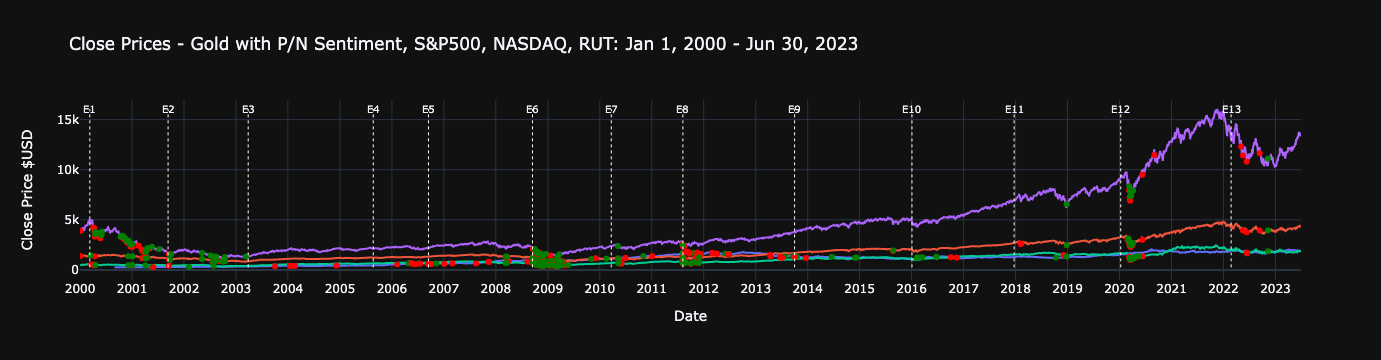

In [23]:
# Create the time series line plot for 'gold_df'
fig = go.Figure()

# Create the time series line plot for 'filtered_gold_df'
fig.add_trace(go.Scatter(
    x=gold.index,
    y=gold['Close'],
    mode='lines',
    name='Gold Price',
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Close: $%{y:.2f}'
))

# Create the time series line plot for S&P 500
fig.add_trace(go.Scatter(
    x=sp500.index,
    y=sp500['Close'],
    mode='lines',
    name='S&P 500',
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Close: $%{y:.2f}'
))

# Create the time series line plot for DJIA
fig.add_trace(go.Scatter(
    x=russ2000.index,
    y=russ2000['Close'],
    mode='lines',
    name='RUT',
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Close: $%{y:.2f}'
))

# Create the time series line plot for Nasdaq Composite Index
fig.add_trace(go.Scatter(
    x=nasdaq.index,
    y=nasdaq['Close'],
    mode='lines',
    name='NASDAQ',
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Close: $%{y:.2f}'
))

# Update the x-axis range to include time range
fig.update_xaxes(range=['2000-01-01', '2023-06-30'])

# Plot the points from 'combined_pn_sentiment' along the 'gold_df' line plot with hovertool
fig.add_trace(go.Scatter(
    x=combined_pn_sentiment.index,
    y=gold.loc[combined_pn_sentiment.index, 'Close'],
    mode='markers',
    name='Gold % Change',
    marker=dict(
        color=combined_pn_sentiment['Percent Change'].apply(lambda x: 'green' if x > 0 else 'red'),
        size=6
    ),
    text=combined_pn_sentiment['Percent Change'],
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Close: $%{y:.2f}<br>Daily Pct Change: %{text:.2f}%'+
                  '<br>News: %{customdata[0]}<br>Price Sentiment: %{customdata[1]}',
    selected=dict(marker=dict(color='rgba(31, 119, 180, 1)', size=6)),
    unselected=dict(marker=dict(opacity=0)),
    customdata=np.column_stack([combined_pn_sentiment['News'], combined_pn_sentiment['Price Sentiment']])
))

# Plot the points from 'sp500_returns' along the 'sp500' line plot with hovertool
fig.add_trace(go.Scatter(
    x=sp500_returns.index,
    y=sp500_returns['Close'],
    mode='markers',
    name='S&P500 % Change',
    marker=dict(
        color=sp500_returns['Daily_Pct_Change'].apply(lambda x: 'green' if x > 0 else 'red'),
        size=6
    ),
    text=sp500_returns['Daily_Pct_Change'],
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Close: $%{y:.2f}<br>Daily Pct Change: %{text:.2f}%',
    selected=dict(marker=dict(color='rgba(31, 119, 180, 1)', size=6)),
    unselected=dict(marker=dict(opacity=0))
))

# Plot the points from 'djia_returns' along the 'djia' line plot with hovertool
fig.add_trace(go.Scatter(
    x=russ2000_returns.index,
    y=russ2000_returns['Close'],
    mode='markers',
    name='RUT % Change',
    marker=dict(
        color=sp500_returns['Daily_Pct_Change'].apply(lambda x: 'green' if x > 0 else 'red'),
        size=6
    ),
    text=russ2000_returns['Daily_Pct_Change'],
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Close: $%{y:.2f}<br>Daily Pct Change: %{text:.2f}%',
    selected=dict(marker=dict(color='rgba(31, 119, 180, 1)', size=6)),
    unselected=dict(marker=dict(opacity=0))
))

# Plot the points from 'nasdaq_returns' along the 'nasdaq' line plot with hovertool
fig.add_trace(go.Scatter(
    x=nasdaq_returns.index,
    y=nasdaq_returns['Close'],
    mode='markers',
    name='NASDAQ % Change',
    marker=dict(
        color=sp500_returns['Daily_Pct_Change'].apply(lambda x: 'green' if x > 0 else 'red'),
        size=6
    ),
    text=nasdaq_returns['Daily_Pct_Change'],
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Close: $%{y:.2f}<br>Daily Pct Change: %{text:.2f}%',
    selected=dict(marker=dict(color='rgba(31, 119, 180, 1)', size=6)),
    unselected=dict(marker=dict(opacity=0))
))

# Add vertical lines for economic events
events = pd.DataFrame({
    'Date': pd.to_datetime(['2000-03-10', '2001-09-11', '2003-03-28', '2005-08-23', '2006-09-15', '2008-09-15', '2010-03-23', '2011-08-08', '2013-10-1', '2016-01-04', '2017-12-22', '2020-01-10', '2022-02-24']),  # Example dates of economic events
    'Event': ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13'],  # Example event descriptions
    'EventDescription': ['<b>2000 Peak DotCom Bubble Burst:</b> The dot-com bubble burst in March 2000, with the technology heavy Nasdaq composite index peaking at $5,048.62 on March 10, more than double its value just a year before. By 2001, the bubbles deflation was running full speed. Between 1995 and its peak in March 2000, the Nasdaq stock market index rose 800%, only to fall 740% from its peak by October 2002, giving up all its gains during the bubble.', 
                         '<b>2001 9/11:</b> The September 11 attacks caused global stock markets to drop sharply. The attacks themselves caused approximately $40 billion in insurance losses, making it one of the largest insured events ever. After the second plane crashed into the south tower, the New York Stock Exchange was evacuated as well as nearly all banks and financial institutions on Wall Street and in many cities across the country. The London Stock Exchange and other stock exchanges around the world were also closed down and evacuated in fear of follow-up terrorist attacks.',
                         '<b>2003 President Bush signs his third tax cut into law:</b> President George W. Bush signs a ten-year $350 billion tax-cut package, the third-largest tax cut in U.S. history, known as the Jobs and Growth Tax Relief Reconciliation Act of 2003 (JGTRRA). Despite promises from proponents of the tax cuts, evidence suggests that they did not improve economic growth or pay for themselves, but instead ballooned deficits and debt and contributed to a rise in income inequality.',
                         '<b>2005 Hurricane Katrina:</b> Hurricane Katrina hit caused approximately $161 billion in damage, and is the costliest hurricane on record. It is estimated the total economic impact to Louisiana and Mississippi may exceed $150 billion.  An estimated 1,833 people died in the hurricane and the flooding that followed. Hundreds of thousands of residents of southern Louisiana and Mississippi, including nearly everyone who lived in New Orleans, were left unemployed. Millions of people were left homeless along the Gulf Coast and in New Orleans.',
                         '<b>2006 US housing bubble burst:</b> The 2000s United States housing bubble was a real estate bubble affecting over half of the US. It was the impetus for the subprime mortgage crisis. Housing prices peaked in early 2006, and started to decline in 2006 and 2007, and reached new lows in 2011. The credit crisis resulting from the bursting of the housing bubble is an important cause of the Global/US Great Recession from 2007-2008.',
                         '<b>2008 Lehman Brothers file for bankruptcy:</b> Lehman Brothers filed for Chapter 11 bankruptcy protection on Monday, September 15, 2008. According to Bloomberg, reports filed with the U.S. Bankruptcy Court, Southern District of New York (Manhattan) on September 16 indicated that JPMorgan Chase & Co. provided Lehman Brothers with a total of $138 billion in "Federal Reserve-backed advances". The filing remains the largest bankruptcy filing in U.S. history, with Lehman holding over $600 billion in assets.',
                         '<b>2010 Affordable Care Act:</b> The Affordable Care Act, also colloquially known as Obamacare, Together with the Health Care and Education Reconciliation Act of 2010 amendment, it represents the US healthcare system’s most significant regulatory overhaul and expansion of coverage since the enactment of Medicare and Medicaid in 1965. The ACAs major provisions came into force in 2014. By 2016, the uninsured share of the population had roughly halved, with estimates ranging from 20 to 24 million additional people covered.',
                         '<b>2011 Black Monday:</b> In finance and investing, Back Monday 2011 refers to August 8, 2011, when US and global stock markets crashed following the Friday night credit rating downgrade by Standard and Poor’s of the United States sovereign debt from AAA, or "risk free", to AA+. It was the first time in history the United States was downgraded. US President Barack Obama attempted to calm the markets during trading in a speech from the White House, but the DOW lost 200 more points within 20 minutes after he concluded.',
                         '<b>2013 US Federal Government Shutdown:</b> From October 1 to October 17, 2013, the United States federal government entered a shutdown focusing on a disagreement between Republican-led House of Representatives and the Democratic-led Senate towards the contents of the 2014 Continuing Appropriations Resolution bill, alongside other political issues. The impact of the U.S. government shutdown was already being felt by the worlds financial markets as stocks fell around the globe on September 30, 2013.',
                         '<b>2016 China’s Market Crashes:</b> In January 4 and 7, China’s stock market saw a sharp sell off of about 7% that quickly sent stocks tumbling globally. From January 4 to 15, China’s stock market fell nearly 18%. The Yuan fell to its lowest level since March 2011 which made Chinese exports more competitive in overseas market and in turn made overseas investments more expensive. The wild swings in global financial markets due to China’s market crash proved beyond doubt that China now plays a bigger role in the functioning of the global economy.',
                         '<b>2017 Tax Cuts and Jobs Act:</b> In December 2017, the most sweeping tax legislation since the Tax Reform Act of 1986 was signed into law. The Tax Cuts and Jobs Act of 2017 (TCJA), which was effective January 1, 2018, permanently lowered the corporate tax rate to 21% and ushered in a broad range of changes, from adjusting individual tax brackets and rates, to nearly doubling the standard deduction. However, the TCJA also eliminates or limits many tax breaks, and much of the tax relief is only temporary.',
                         '<b>2020 Coronavirus:</b> The coronavirus pandemic ushered in quarantines, mask mandates, product shortages, business closures, and businesses scrambling to figure out new ways to keep their doors open, and was felt heavily all over the world. The crisis had a dramatic impact on global poverty and inequality. Global poverty increased for the first time in a generation, and disproportionate income losses among disadvantaged populations led to a dramatic rise in inequality within and across countries.',
                         '<b>2020 Russia-Ukraine war escalation:</b> The Russia-Ukraine conflict that broke out in late February 2022 pushed up global food and energy prices. Gas prices rose nearly five times on March 7 compared to before the conflict. The retaliatory sanctions between the US, Europe and Russia have caused oil and gas supplies to drop and their prices to rise sharply. Geopolitical tensions and natural disasters have disrupted global supply chains, exacerbated inflation, and resulted in growth slowdown.']  # Example event descriptions
})

# Add invisible markers for hover tooltips on vertical lines
for event in events.itertuples():
    fig.add_trace(go.Scatter(
        x=[event.Date, event.Date],
        y=[gold['Close'].min(), sp500['Close'].max()],
        mode='markers',
        marker=dict(
            size=0,
            color='rgba(0, 0, 0, 0)'
        ),
        hovertemplate='<br>'.join(textwrap.wrap(event.EventDescription, width=30))
    ))

# Add vertical lines for economic events
for event in events.itertuples():
    fig.add_shape(
        type='line',
        x0=event.Date,
        y0=gold['Close'].min(),
        x1=event.Date,
        y1=nasdaq['Close'].max(),
        line=dict(color='white', width=1, dash='dot')
    )
    fig.add_annotation(
        x=event.Date,
        y=nasdaq['Close'].max(),
        text=event.Event,
        showarrow=False,
        font=dict(size=10),
        hovertext='<br>'.join(textwrap.wrap(event.EventDescription, width=30))  # Wrap text and join with line breaks
    )   
    
# Update the layout with a dark theme
fig.update_layout(
    title='Close Prices - Gold with P/N Sentiment, S&P500, NASDAQ, RUT: Jan 1, 2000 - Jun 30, 2023',
    xaxis=dict(title='Date', dtick='M12'),
    yaxis=dict(title='Close Price $USD'),
    hovermode='closest',  # Enable hover events and display closest hover data
    template=pio.templates["plotly_dark"], # Apply the dark theme template
    showlegend=False,
)

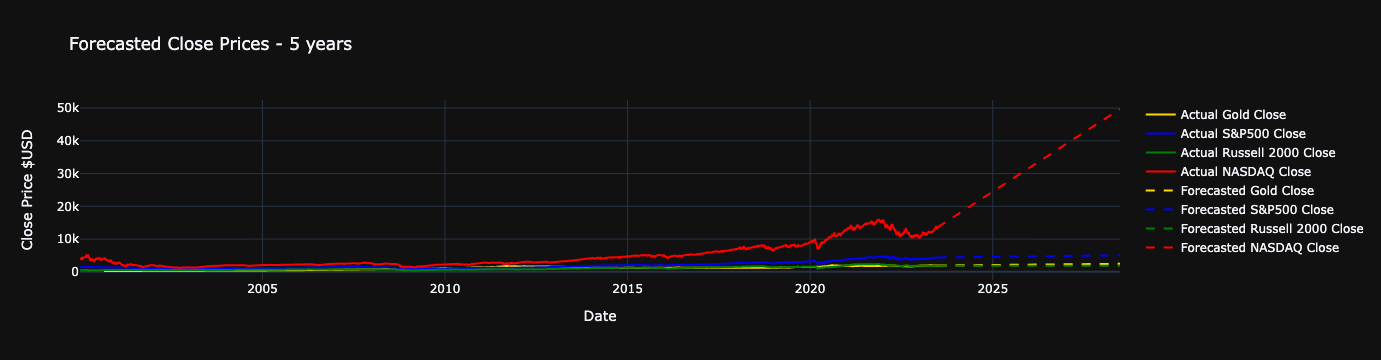

In [24]:
# Create Plotly figure
fig1 = go.Figure()

# Add actual close prices
fig1.add_trace(go.Scatter(
    x=training_data_gold.index,
    y=training_data_gold['Close'],
    name='Actual Gold Close',
    mode='lines',
    line=dict(color='gold'),
    hovertemplate='Date: %{x}<br>Close: $%{y:.2f}<extra></extra>'
))

fig1.add_trace(go.Scatter(
    x=training_data_sp500.index,
    y=training_data_sp500['Close'],
    name='Actual S&P500 Close',
    mode='lines',
    line=dict(color='blue'),
    hovertemplate='Date: %{x}<br>Close: $%{y:.2f}<extra></extra>'
))

fig1.add_trace(go.Scatter(
    x=training_data_russ2000.index,
    y=training_data_russ2000['Close'],
    name='Actual Russell 2000 Close',
    mode='lines',
    line=dict(color='green'),
    hovertemplate='Date: %{x}<br>Close: $%{y:.2f}<extra></extra>'
))

fig1.add_trace(go.Scatter(
    x=training_data_nasdaq.index,
    y=training_data_nasdaq['Close'],
    name='Actual NASDAQ Close',
    mode='lines',
    line=dict(color='red'),
    hovertemplate='Date: %{x}<br>Close: $%{y:.2f}<extra></extra>'
))

# Add forecasted values and confidence intervals
fig1.add_trace(go.Scatter(
    x=forecast_df_gold['Date'],
    y=forecast_df_gold['Forecast'],
    name='Forecasted Gold Close',
    mode='lines',
    line=dict(color='gold', dash='dash'),
    hovertemplate='Date: %{x}<br>Forecast: $%{y:.2f}<extra></extra>'
))

fig1.add_trace(go.Scatter(
    x=forecast_df_sp500['Date'],
    y=forecast_df_sp500['Forecast'],
    name='Forecasted S&P500 Close',
    mode='lines',
    line=dict(color='blue', dash='dash'),
    hovertemplate='Date: %{x}<br>Forecast: $%{y:.2f}<extra></extra>'
))

fig1.add_trace(go.Scatter(
    x=forecast_df_russ2000['Date'],
    y=forecast_df_russ2000['Forecast'],
    name='Forecasted Russell 2000 Close',
    mode='lines',
    line=dict(color='green', dash='dash'),
    hovertemplate='Date: %{x}<br>Forecast: $%{y:.2f}<extra></extra>'
))

fig1.add_trace(go.Scatter(
    x=forecast_df_nasdaq['Date'],
    y=forecast_df_nasdaq['Forecast'],
    name='Forecasted NASDAQ Close',
    mode='lines',
    line=dict(color='red', dash='dash'),
    hovertemplate='Date: %{x}<br>Forecast: $%{y:.2f}<extra></extra>'
))

# Add layout
fig1.update_layout(
    title='Forecasted Close Prices - 5 years',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close Price $USD'),
    template='plotly_dark'
)

In [25]:
# Set the desired theme
pn.extension(theme='dark')

# Set the desired width for the plots
plot_width = 1500

# Update the layout.width property of fig and fig1
fig.update_layout(width=plot_width)
fig1.update_layout(width=plot_width)

# Create a sidebar for descriptions
sidebar = pn.Column(
    pn.pane.Markdown("**Top Close Prices Plot Info:** E1,2,3+ = Economic Events | Gold = Blue | NASDAQ = Purple | S&P 500 = Red | Russell 2000 = Turquiose Green | E1,2,3+ = Economic Events | red+green dots = major daily percent changes | gold sentiment data ends 2019. ", style={"margin-bottom": "10px"}),
    pn.pane.Markdown("**Gold:** This is a precious metal that has been used as a store of value for centuries. Investors often turn to gold as a safe haven asset in times of economic uncertainty. The price of gold is tracked in real-time, like other commodities, and it can be invested in various ways, including physical gold (like gold bars and coins), gold ETFs, gold futures, and gold mining stocks.", style={"margin-bottom": "10px"}),
    pn.pane.Markdown("**S&P 500:** This is a stock market index that measures the performance of 500 large companies listed on the US stock exchanges. It's considered one of the best representations of the U.S. stock market and a bellwether for the U.S. economy. ", style={"margin-bottom": "10px"}),
    pn.pane.Markdown("**NASDAQ Composite Index:** This index includes all the stocks that are listed on the NASDAQ stock market, including technology and internet-related companies like Apple, Amazon, Microsoft, and Google's parent company, Alphabet. The NASDAQ Composite is heavily skewed towards technology companies and is often used as a gauge of how tech stocks are performing. ", style={"margin-bottom": "10px"}),
    pn.pane.Markdown("**Russell 2000 Index:** This index tracks 2000 small-cap companies in the United States and is often used as a benchmark for small-cap performance. Small-cap companies are generally considered to have a market capitalization between $300 million and $2 billion. ", style={"margin-bottom": "10px"}),
)

# Create a column for the plots
plots_column = pn.Column(
    pn.Row(fig),
    pn.Row(fig1),
)

# Create a title row with customized CSS
title_row = pn.Row(
    pn.pane.Markdown("# Chronological Analysis and Forecasting: A Comparative Interactive Visualization Study of Gold and Stock Indices - @djohnst914", width_policy='max', sizing_mode="stretch_width"),
    css_classes=['no-wrap-title'],
)

# Create a row for the plots and sidebar
content_row = pn.Row(plots_column, sidebar, width_policy='max')

# Combine the title row and content row into a single column layout
app_layout = pn.Column(
    title_row,
    content_row,
)

# Display the app
app_layout.servable()

Column
    [0] Row(css_classes=['no-wrap-title'])
        [0] Markdown(str, sizing_mode='stretch_width', width_policy='max')
    [1] Row(width_policy='max')
        [0] Column
            [0] Row
                [0] Plotly(Figure)
            [1] Row
                [0] Plotly(Figure)
        [1] Column
            [0] Markdown(str, style={'margin-bottom': '10px'})
            [1] Markdown(str, style={'margin-bottom': '10px'})
            [2] Markdown(str, style={'margin-bottom': '10px'})
            [3] Markdown(str, style={'margin-bottom': '10px'})
            [4] Markdown(str, style={'margin-bottom': '10px'})

In [27]:
def create_app():
    return app_layout

pn.serve(create_app)

warnings.filterwarnings('ignore')

Launching server at http://localhost:50736
